In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prince

In [37]:
train = pd.read_csv('data/train.csv')
validation = pd.read_csv('data/validation.csv')
test = pd.read_csv('data/test.csv')
etrain = pd.read_csv('data/train.csv')
evalidation = pd.read_csv('data/validation.csv')
etest = pd.read_csv('data/test.csv')
numeric_features = np.load('numeric_features.npy')

<AxesSubplot:>

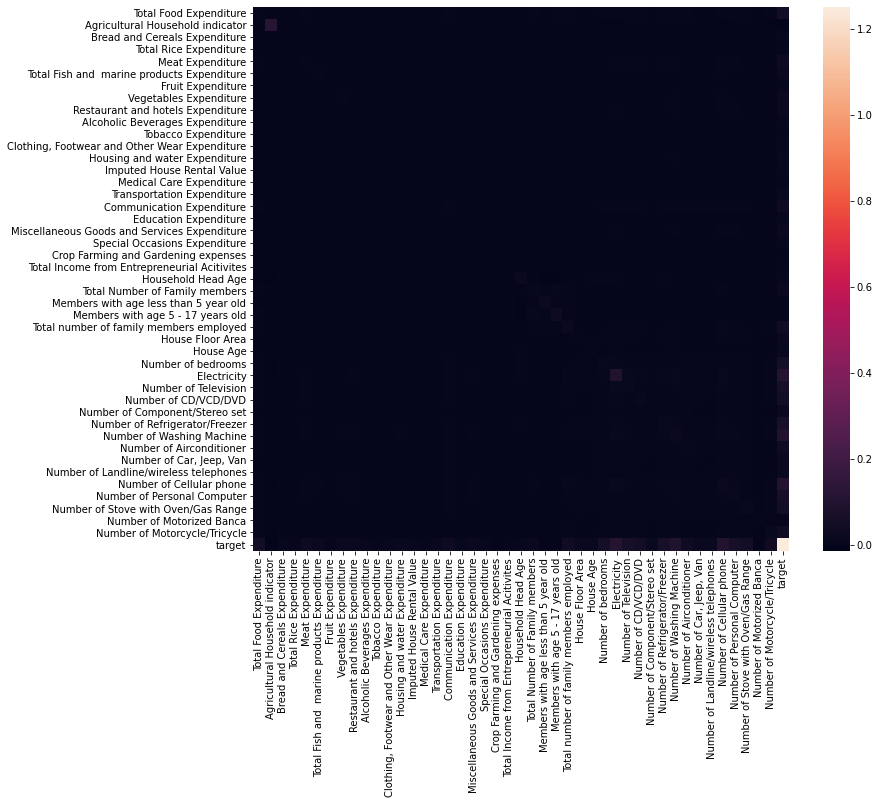

In [118]:
import seaborn as sns
dataset = pd.read_csv('dataset.csv')
plt.figure(figsize=(12, 10))
sns.heatmap(train.corr())

In [3]:
print(len(train))
print(train['target'].value_counts())
print(len(test))
print(test['target'].value_counts())
print(len(validation))
print(validation['target'].value_counts())

26588
2    6688
3    6666
0    6648
1    6586
Name: target, dtype: int64
8309
2    2110
1    2090
3    2058
0    2051
Name: target, dtype: int64
6647
1    1709
0    1688
3    1662
2    1588
Name: target, dtype: int64


## Classifier

### Numeric classifier

#### LogisticRegression

##### No reduction

In [54]:
x_train = train.drop(['target'], axis=1).loc[:, numeric_features]
y_train = train[['target']]
x_validation = validation.drop(['target'], axis=1).loc[:, numeric_features]
y_validation = validation[['target']]
x_test = test.drop(['target'], axis=1).loc[:, numeric_features]
y_test = test[['target']]

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

clf = LogisticRegression(penalty='l2',random_state=20, max_iter=250, multi_class='multinomial', solver='saga', n_jobs=4)
result = cross_validate(clf, x_train, y_train.values.ravel(), cv=5)
print("Cross-validation score: ", result['test_score'].mean())

Cross-validation score:  0.6926804774371418


In [6]:
clf = clf.fit(x_train, y_train.values.ravel())
result = clf.score(x_train, y_train)
print("Train score: ", result)
result = clf.score(x_validation, y_validation)
print("Validation score: ", result)
result = clf.score(x_test, y_test)
print("Test score: ", result)

Train score:  0.6996389348578306
Validation score:  0.691740634872875
Test score:  0.6968347574918763


In [7]:
from sklearn.metrics import classification_report
def report(clf, x, y):
    y_pred = clf.predict(x)
    print(classification_report(y, y_pred))
report(clf, x_test, y_test)

              precision    recall  f1-score   support

           0       0.72      0.81      0.76      2051
           1       0.57      0.55      0.56      2090
           2       0.63      0.62      0.62      2110
           3       0.88      0.81      0.84      2058

    accuracy                           0.70      8309
   macro avg       0.70      0.70      0.70      8309
weighted avg       0.70      0.70      0.70      8309



In [69]:
x_train

,Total Food Expenditure,Agricultural Household indicator,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,Alcoholic Beverages Expenditure,...,Number of Refrigerator/Freezer,Number of Washing Machine,Number of Airconditioner,"Number of Car, Jeep, Van",Number of Landline/wireless telephones,Number of Cellular phone,Number of Personal Computer,Number of Stove with Oven/Gas Range,Number of Motorized Banca,Number of Motorcycle/Tricycle
0,0.171021,0.0,0.054862,0.039503,0.089675,0.063440,0.013040,0.071003,0.041801,0.126611,...,0.2,0.000000,0.0,0.0,0.25,0.5,0.333333,0.333333,0.0,0.2
1,0.068537,0.5,0.018981,0.011184,0.012689,0.030588,0.004675,0.026537,0.000414,0.065109,...,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0
2,0.066864,0.0,0.016250,0.010259,0.047556,0.035238,0.002897,0.058302,0.010134,0.084760,...,0.0,0.000000,0.0,0.0,0.00,0.1,0.000000,0.000000,0.0,0.2
3,0.088754,0.0,0.031611,0.028873,0.061965,0.051305,0.008767,0.042380,0.006480,0.002014,...,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0
4,0.048207,0.0,0.020038,0.018791,0.009500,0.048170,0.001304,0.018262,0.013760,0.000000,...,0.6,0.000000,0.0,0.0,0.00,0.2,0.000000,0.333333,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26583,0.091611,0.0,0.055498,0.036422,0.008048,0.060773,0.005242,0.068503,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0
26584,0.042946,0.0,0.021260,0.014400,0.008254,0.030318,0.007360,0.045414,0.000717,0.002265,...,0.0,0.333333,0.2,0.0,0.00,0.1,0.000000,0.000000,0.0,0.0
26585,0.079842,0.0,0.017149,0.011328,0.053275,0.026099,0.001224,0.015909,0.044216,0.000000,...,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0
26586,0.076279,0.0,0.047612,0.047308,0.012135,0.035105,0.002758,0.072045,0.003792,0.009062,...,0.0,0.000000,0.0,0.0,0.00,0.3,0.000000,0.000000,0.0,0.2


#### Reduction

In [89]:
pca_p = prince.PCA(n_components=3, n_iter=1000, copy=True, check_input=True, engine='auto', random_state=42)
pca_p = pca_p.fit(x_train)
tmp = pca_p.transform(x_train)

In [97]:
tmp[2]

0        0.158329
1        0.330069
2       -0.588574
3        0.499196
4       -2.669199
           ...   
26583    1.263627
26584   -0.918949
26585    1.396399
26586   -0.913771
26587   -0.751143
Name: 2, Length: 26588, dtype: float64

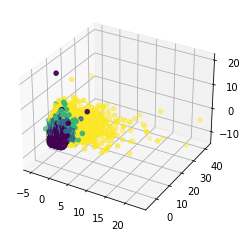

In [112]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tmp[2].values.ravel().tolist(), tmp[0].values.ravel().tolist(), tmp[1].values.ravel().tolist(), c=y_train)

<AxesSubplot:title={'center':'Row principal coordinates'}, xlabel='Component 1 (8.29% inertia)', ylabel='Component 2 (4.07% inertia)'>

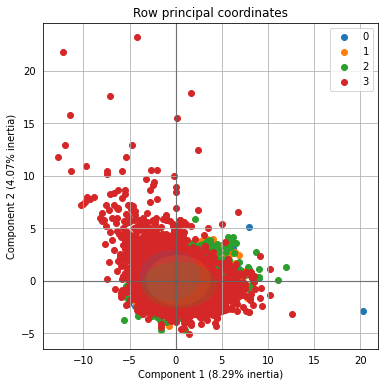

In [92]:
pca_p.plot_row_coordinates(x_train, x_component=1,y_component=2, color_labels=y_train.values.ravel())

In [115]:
result = pca_p.column_correlations(x_train)
tmp = result.abs().idxmax()
result.loc[tmp, :]

,0,1,2
Total Food Expenditure,0.842463,0.348896,0.036704
Total Number of Family members,0.242596,0.823196,0.065542
Electricity,0.295039,-0.073641,-0.513227


In [110]:
reduced_x_train = pca_p.transform(x_train)

clf = LogisticRegression(penalty='l2', random_state=20, max_iter=1000, multi_class='multinomial', solver='saga', n_jobs=4)
clf = clf.fit(reduced_x_train, y_train.values.ravel())

result_train = clf.score(reduced_x_train, y_train)
print("Train score: ", result_train)
reduced_x_validation = pca_p.transform(x_validation)
result_validation = clf.score(reduced_x_validation, y_validation)
print("Validation score: ", result_validation)
reduced_x_test = pca_p.transform(x_test)
result_test = clf.score(reduced_x_test, y_test)
print("Test score: ", result_test)

Train score:  0.6938092372498872
Validation score:  0.7021212577102453
Test score:  0.6839571548922855


In [28]:
xx_train = train.drop(['target'], axis=1).loc[:, numeric_features]
yy_train = train[['target']]
xx_train = pca_p.transform(xx_train)

reduced_clf = LogisticRegression(penalty='l2', random_state=20, max_iter=1000, multi_class='multinomial', solver='saga')
result = cross_validate(reduced_clf, xx_train, yy_train.values.ravel(), cv=5)
print("Cross-validation score: ", result['test_score'].mean())

Cross-validation score:  0.7456745742278752


In [13]:
report(clf, reduced_x_test, y_test)

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      2051
           1       0.64      0.66      0.65      2090
           2       0.67      0.66      0.66      2110
           3       0.89      0.82      0.85      2058

    accuracy                           0.74      8309
   macro avg       0.75      0.74      0.75      8309
weighted avg       0.75      0.74      0.74      8309



### Perceptron

In [36]:
from sklearn.linear_model import Perceptron
from sklearn.model_selection import GridSearchCV
p = Perceptron(random_state=20, n_jobs=4)
p = GridSearchCV(p, {'penalty': ['l1', 'l2'], 'eta0': np.linspace(0.0001, 1, 1000)}, n_jobs=-1)
p.fit(x_train, y_train.values.ravel())
result = p.score(x_train, y_train)
print("Train score: ", result)
result = p.score(x_validation, y_validation)
print("Validation score: ", result)
result = p.score(x_test, y_test)
print("Test score: ", result)

Train score:  0.6212953211975327
Validation score:  0.6088460959831503
Test score:  0.6180045733541942
